# Climate Change Analysis 
* Student name: Chris Hollman
* Student pace: Self paced
* Scheduled review date/time: 
* Instructor name: Abhineet Kulkarni

## Project Overview
The goal of this project is to study the trends of our global climate. This will include an analysis of historical data, a prediction of future trends, and a regresssion model to determine associated factors. 

In [755]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from neuralprophet import NeuralProphet
import warnings
from sklearn.metrics import mean_absolute_error

In [907]:
global_df = pd.read_csv('data/GlobalTemperatures.csv')
hist_gas_df = pd.read_csv('data/historical_emissions.csv')
pop_df = pd.read_csv('data/20_year_world_pop.csv')
gdp_df = pd.read_csv('data/gdp_growth.csv')


## Initial Data Exploration for Timeseries
We will start with a timeseries model to identify trends and predict future temperatures. Later we will build some regression models to identify correlations with a number of other factors. For our purposes we will just focus on the global temperature dataset.

In [949]:
pop_df[pop_df['Location']== 'World']

,Unnamed: 0,Location,Time,PopMale,PopFemale,PopTotal,PopDensity
9380,9380,World,2001,"3133601,761","3089024,77","6222626,531",47.832
9381,9381,World,2002,"3173900,449","3127872,723","6301773,172",48.440
9382,9382,World,2003,"3214422,031","3166763,11","6381185,141",49.051
9383,9383,World,2004,"3255262,626","3205896,765","6461159,391",49.665
9384,9384,World,2005,"3296485,267","3245421,689","6541906,956",50.286
9385,9385,World,2006,"3338132,929","3285384,988","6623517,917",50.913
9386,9386,World,2007,"3380183,02","3325763,623","6705946,643",51.547
9387,9387,World,2008,"3422546,382","3366542,29","6789088,672",52.186
9388,9388,World,2009,"3465089,423","3407677,565","6872766,988",52.829
9389,9389,World,2010,"3507703,635","3449119,953","6956823,588",53.475


There are columns for both land and land/ocean min, max, and average temperatures. The ocean temperatures seem to have not been recorded until around l00 years later than land temps. 

In [759]:
#Converting time stamp column to datetime format
global_df['dt'] = pd.to_datetime(global_df['dt'])

In [760]:
print("lowest uncertainty:", global_df['LandAverageTemperatureUncertainty'].min())
print("highest uncertainty:", global_df['LandAverageTemperatureUncertainty'].max())

lowest uncertainty: 0.034
highest uncertainty: 7.88


There is an extremely large difference in uncertainty as recording methods have become more sophisticated. The highest uncertaintly is +/- 7.88 degrees Celcius (14.8 degrees Farenheit). I've decided to trim the least accurate quartile of data.

In [761]:
global_df['LandAverageTemperatureUncertainty'].describe()

count    3180.000000
mean        0.938468
std         1.096440
min         0.034000
25%         0.186750
50%         0.392000
75%         1.419250
max         7.880000
Name: LandAverageTemperatureUncertainty, dtype: float64

In [762]:
#as expected, the uncertainty values for earlier dates tend to be on the high side
global_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [763]:
#more recent temperatures are accurate within +/- two tenths of a degree Farenheit
global_df.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


In [764]:
#determining the latest month with an uncertainty greater than cutoff threshold
global_df[global_df['LandAverageTemperatureUncertainty']>1.4].tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1155,1846-04-01,7.473,1.729,NaN,NaN,NaN,NaN,NaN,NaN
1166,1847-03-01,4.046,1.583,NaN,NaN,NaN,NaN,NaN,NaN
1177,1848-02-01,3.726,1.437,NaN,NaN,NaN,NaN,NaN,NaN
1237,1853-02-01,2.228,1.492,8.29,1.535,-3.213,1.783,13.362,0.457
1260,1855-01-01,2.522,1.465,8.22,1.099,-3.125,1.699,13.384,0.442


In [765]:
#dropping all dates prior to 1856(the last year in which every recorded temp was within desired uncertainty range)
global_df = global_df[global_df['dt'] >= '1856']

In [766]:
#converting temps the Farenheit for interpretability
global_df['y'] = global_df['LandAverageTemperature']*1.8+32
global_df.rename(columns = {'dt':'ds'}, inplace = True)

## Prophet Model
Since there are no other obvious cleaning or preperation needed for our remaining data, we can start with a simple, useful model using NeuralProphet. This model calls for there to be only two columns, one with the datetime values that needs to be called 'dt' and one with the temperature values which needs to be called 'y'

In [767]:
#dropping unneccessary columns and formatting for Neural Prophet
drop_columns = ['LandAverageTemperature',
                'LandAverageTemperatureUncertainty',
                'LandMaxTemperature',
                'LandMaxTemperatureUncertainty',
                'LandMinTemperature',
                'LandMinTemperatureUncertainty',
                'LandAndOceanAverageTemperature',
                'LandAndOceanAverageTemperatureUncertainty']
ts = global_df.drop(drop_columns, axis=1)
ts.head()

,ds,y
1272,1856-01-01,36.9680
1273,1856-02-01,36.0068
1274,1856-03-01,39.8696
1275,1856-04-01,45.9518
1276,1856-05-01,50.9540


In [768]:
#taking a small sampple to take an initial look at the data
temp_1990_2000 = ts[ts['ds'].between('1990-01-01','2000-01-01')]
X = temp_1990_2000['ds']
y = temp_1990_2000['y']

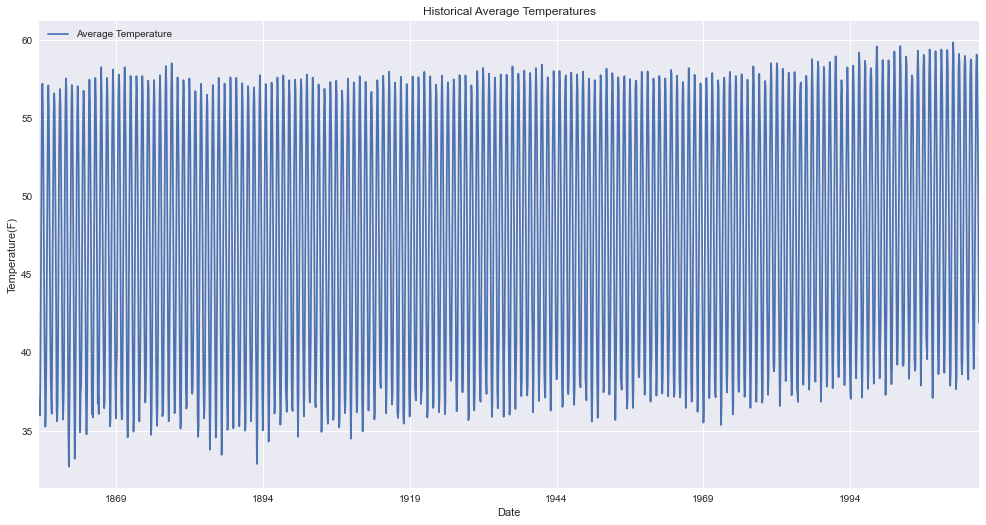

In [769]:
pd.plotting.register_matplotlib_converters()
ax = ts.set_index('ds').plot(figsize=(15, 8))
ax.set_title('Historical Average Temperatures')
ax.set_ylabel('Temperature(F)')
ax.set_xlabel('Date')
ax.legend(['Average Temperature']);

From this broad veiw, we can see that there is an overall upward trend. As expected there is some yearly seasonality that the model should automatically pick up on.

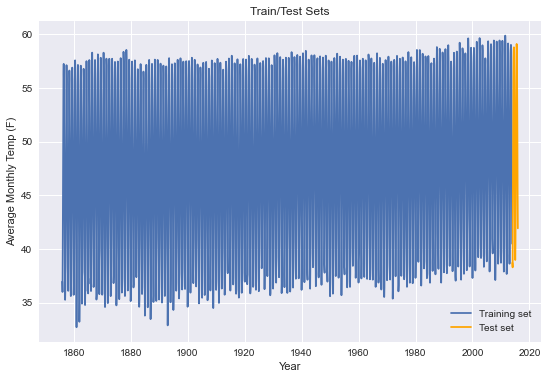

In [770]:
#splitting off last 2 years of data as a test set

ts_train = ts[ts['ds'] < pd.Timestamp('2014-01-01')]
ts_test = ts[ts['ds'] >= pd.Timestamp('2014-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(ts_train['ds'], ts_train['y'], label='Training set')
plt.plot(ts_test['ds'], ts_test['y'], label='Test set', color='orange')
plt.xlabel('Year')
plt.ylabel('Average Monthly Temp (F)')
plt.legend();

In [771]:
#checking test set dates
ts_test

,ds,y
3168,2014-01-01,38.7176
3169,2014-02-01,38.3000
3170,2014-03-01,43.4804
3171,2014-04-01,49.2602
3172,2014-05-01,54.6476
3173,2014-06-01,57.8030
3174,2014-07-01,58.7714
3175,2014-08-01,58.7750
3176,2014-09-01,55.5638
3177,2014-10-01,50.5940


## Intitial Modeling
The next step is to fit a NeuralProphet model to the timeseries. For the baseline model the only parameters we'll pass will be to prioritize MAE as the preferred metric to optimize. Once used to predict the test set, the model will return a validation MAE score as well as the components (trend and seasonality) applied to make the predictions. If the resulting MAE score is satisfactory, we can then broadcast those prediction out for future forecasts. For something as gradual as global temperature averages, we will try a longer term forecast of 30 years.

In [772]:
#fitting 'vanilla' NeuralProphet with MAE as loss function. 
m = NeuralProphet(loss_func='MAE')
m.fit(ts_train, validation_df=ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.79E-01, min: 1.19E+00


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-01, min: 5.41E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.40E-01
  0%|                                                   | 0/160 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /Users/christopherhollman/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

WARNING - (py.warnings._showwarnmsg) - /Users/christopherhollman/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([872])) that is different to the input size (torch.Size([872, 1])). This will likely lead to incorrect re

,L1Loss,MAE,RMSE,Loss,RegLoss,L1Loss_val,MAE_val,RMSE_val
0,0.599768,15.023475,19.686883,0.443693,0.0,0.551164,13.805987,17.918501
1,0.495465,12.410797,17.302317,0.362726,0.0,0.493573,12.363410,16.157936
2,0.390244,9.775155,14.603321,0.282555,0.0,0.449926,11.270102,14.525035
3,0.283243,7.094904,11.592933,0.200742,0.0,0.407940,10.218418,12.653169
4,0.163964,4.107097,7.232253,0.112497,0.0,0.343199,8.596728,10.528248
...,...,...,...,...,...,...,...,...
155,0.019626,0.491603,0.641951,0.014347,0.0,0.347480,8.703951,10.746386
156,0.019433,0.486764,0.637220,0.014158,0.0,0.347403,8.702020,10.743549
157,0.019451,0.487213,0.635208,0.014169,0.0,0.347307,8.699619,10.741983
158,0.019322,0.483994,0.634728,0.014077,0.0,0.347454,8.703305,10.745025


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


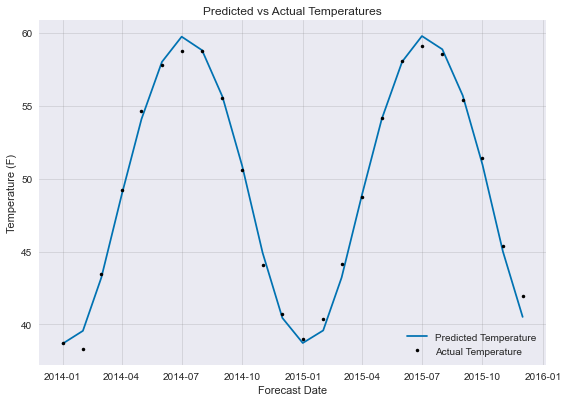

In [773]:
forecast = m.predict(ts_test)
ax = plt.subplot()
plot= m.plot(forecast, ax = ax)
ax.set_title('Predicted vs Actual Temperatures')
ax.set_xlabel('Forecast Date')
ax.set_ylabel('Temperature (F)')
ax.legend(['Predicted Temperature', 'Actual Temperature']);

In [774]:
forecast

,ds,y,residual1,yhat1,trend,season_yearly
0,2014-01-01,38.7176,-0.046534,38.671066,49.426006,-10.754941
1,2014-02-01,38.3000,1.257541,39.557541,49.429932,-9.872388
2,2014-03-01,43.4804,-0.266098,43.214302,49.433472,-6.219171
3,2014-04-01,49.2602,-0.350868,48.909332,49.437401,-0.528065
4,2014-05-01,54.6476,-0.548403,54.099197,49.441196,4.658000
5,2014-06-01,57.8030,0.217462,58.020462,49.445122,8.575343
6,2014-07-01,58.7714,0.984002,59.755402,49.448917,10.306482
7,2014-08-01,58.7750,0.048624,58.823624,49.452843,9.370784
8,2014-09-01,55.5638,0.068288,55.632088,49.456764,6.175326
9,2014-10-01,50.5940,0.279718,50.873718,49.460564,1.413155


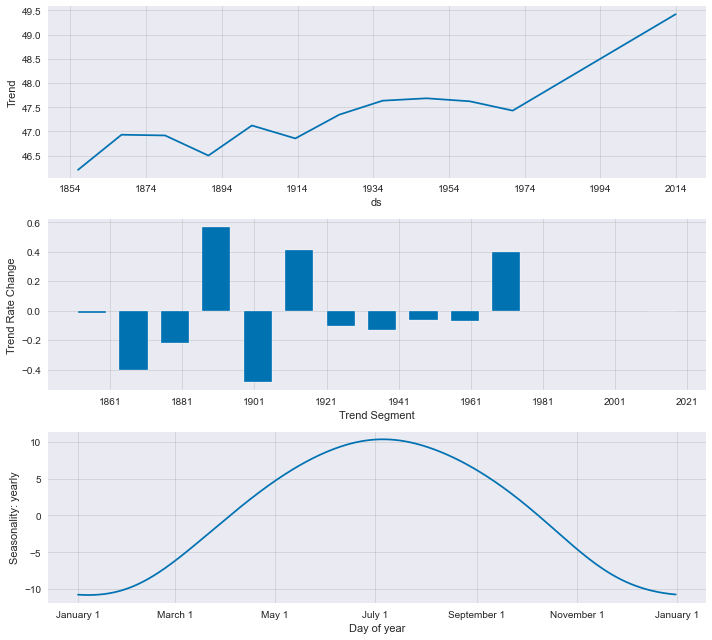

In [775]:
params = m.plot_parameters()

In [776]:
future_dates = m.make_future_dataframe(periods = 360, df = ts_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [777]:
forecast = m.predict(future_dates)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


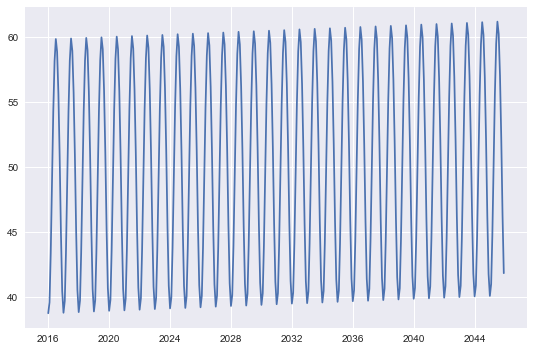

In [778]:
plt.plot(forecast['ds'], forecast['yhat1']);

In [779]:
forecast.groupby(pd.Grouper(key="ds", freq="Y")).mean()


,yhat1,trend,season_yearly
ds,,,
2016-12-31,49.496895,49.539590,-0.042694
2017-12-31,49.548368,49.585811,-0.037442
2018-12-31,49.594337,49.632012,-0.037675
2019-12-31,49.640307,49.678213,-0.037906
2020-12-31,49.681826,49.724520,-0.042694
2021-12-31,49.733300,49.770742,-0.037442
2022-12-31,49.779269,49.816943,-0.037675
2023-12-31,49.825238,49.863145,-0.037906
2024-12-31,49.866757,49.909450,-0.042694


## LSTM Model
Next we will apply and LSTM (Long Short Term Memory) Model to the same timeseries data. This is a bit more involved than Prophet, which automates many of the following steps. 

## Cleaning/Preprocessing Regressing DataFrames
The last step in this project will be to run a regression model that takes possible contributers to climate change into account

In [780]:
temp_year_df = ts.groupby(pd.Grouper(key="ds", freq="Y")).mean().reset_index()
temp_year_df['ds'] = temp_year_df['ds'].dt.year


In [781]:
temp_year_df.set_index('ds', inplace = True)
temp_year_df

,y
ds,
1856,46.39265
1857,45.96470
1858,46.58045
1859,46.85360
1860,46.32950
...,...
2011,49.12880
2012,49.11320
2013,49.29170


In [820]:
drop_columns = ['Country', 'Sector','Data source', 'Gas', 'Unit']
gas_df = hist_gas_df[hist_gas_df['Country'] == 'World'].drop(columns = drop_columns).transpose()
gas_df.index = pd.to_datetime(gas_df.index)
gas_df.index = gas_df.index.year
gas_df

,0
2018,36441.55
2017,35588.70
2016,35160.60
2015,34521.91
2014,34558.59
2013,34217.18
2012,33620.34
2011,33226.01
2010,33328.38
2009,31769.89


In [828]:
pop_drop_columns = ['Location', 'PopMale', 'PopFemale', 'Unnamed: 0']
pop_df = pop_df[pop_df['Location'] == 'World']
final_pop = pop_df.set_index('Time').drop(columns = pop_drop_columns)
final_pop

,PopTotal,PopDensity
Time,,
2001,"6222626,531",47.832
2002,"6301773,172",48.440
2003,"6381185,141",49.051
2004,"6461159,391",49.665
2005,"6541906,956",50.286
2006,"6623517,917",50.913
2007,"6705946,643",51.547
2008,"6789088,672",52.186
2009,"6872766,988",52.829


In [910]:
gdp_df

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863,4.198232,0.300000,5.700001,2.100000,1.999999,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.972652,4.308370,3.986754,2.925591,2.019391,2.542298,2.475272,2.077898,-2.939186,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.752287,5.600745,2.724543,1.451315,2.260314,2.647003,1.189228,3.911603,-2.351101,NaN
3,Africa Western and Central,AFW,NaN,1.848719,3.770212,7.272501,5.396356,4.049794,-1.787094,-9.546521,...,5.142964,6.104241,5.927350,2.745937,0.127595,2.318042,2.952230,3.190336,-0.884981,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.542188,4.954545,4.822628,0.943572,-2.580050,-0.147213,-2.003630,-0.624644,-5.399987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.712195,5.340908,3.348804,5.916270,5.571757,4.825690,3.406631,4.756831,-5.340275,NaN
262,"Yemen, Rep.",YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.392886,4.823415,-0.188574,-27.994546,-9.375124,-5.071796,0.752447,NaN,NaN,NaN
263,South Africa,ZAF,NaN,3.844751,6.177883,7.373613,7.939782,6.122761,4.438308,7.196576,...,2.396232,2.485468,1.413826,1.321862,0.664552,1.157947,1.487617,0.113054,-6.431975,NaN
264,Zambia,ZMB,NaN,1.361382,-2.490839,3.272393,12.214048,16.647456,-5.570310,7.919697,...,7.597593,5.057232,4.697992,2.920375,3.776679,3.504336,4.034494,1.441306,-2.785055,NaN


In [920]:
gdp_drop_columns = ['Code', 'Country Name']
world_gdp = gdp_df[gdp_df['Country Name'] == "World"].drop(columns=gdp_drop_columns).transpose()
world_gdp = world_gdp.dropna()
world_gdp.index = pd.to_datetime(world_gdp.index)
world_gdp.index = world_gdp.index.year
world_gdp

,259
1961,3.800832
1962,5.320280
1963,5.192421
1964,6.568749
1965,5.555097
1966,5.718964
1967,4.164601
1968,5.951520
1969,5.831523
1970,3.917431


In [944]:
 mapping = {
     reg_df.columns[0]:'Pop_Total', 
     reg_df.columns[1]: 'PopDensity', 
     reg_df.columns[2]:'GdpGrowth', 
     reg_df.columns[3]: 'Emissions',
     reg_df.columns[4]:'AverageTemp'
}

reg_df = final_pop.join(world_gdp).join(gas_df).join(temp_year_df)
col_dict = {259:'GdpGrowth', 0: 'Emissions', 'y': 'AverageTemp'}
reg_df.rename(columns = mapping, inplace=True)


In [946]:
reg_df.reset_index()

,Time,Pop_Total,PopDensity,GdpGrowth,Emissions,AverageTemp
0,2001,"6222626,531",47.832,2.000111,25726.42,48.94625
1,2002,"6301773,172",48.440,2.337281,26486.63,49.22675
2,2003,"6381185,141",49.051,3.159531,27308.37,49.14605
3,2004,"6461159,391",49.665,4.480070,28826.48,48.78425
4,2005,"6541906,956",50.286,4.048361,29663.75,49.46165
5,2006,"6623517,917",50.913,4.495723,30905.93,49.15850
6,2007,"6705946,643",51.547,4.438864,31608.28,49.51790
7,2008,"6789088,672",52.186,2.000950,31856.76,48.97715
8,2009,"6872766,988",52.829,-1.307019,31769.89,49.10945
9,2010,"6956823,588",53.475,4.494860,33328.38,49.46555
